In [ ]:
# Importations nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import seaborn as sns
import string
import nltk
from transformers import BertTokenizer

# Téléchargement des ressources NLTK
nltk.download('punkt')
nltk.download('stopwords')

# Chargement des fichiers CSV
train_df = pd.read_csv("train-m.csv", on_bad_lines='skip')
val_df = pd.read_csv("val-m.csv", on_bad_lines='skip')
test_df = pd.read_csv("test-m.csv", on_bad_lines='skip')
scores_df = pd.read_csv("test_scores-m.csv", on_bad_lines='skip')  # facultatif

# Load your BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

df = pd.concat([train_df, val_df, test_df], ignore_index=True)

# Tokenize using BERT for consistent downstream usage
df['bert_tokens'] = df['text'].apply(lambda x: tokenizer.tokenize(str(x)))
df['bert_token_len'] = df['bert_tokens'].apply(len)

# Class distribution
class_counts = df['label'].value_counts().sort_index()
print("Nombre de textes par niveau :\n", class_counts)

# Average length per class
avg_length = df.groupby('label')['bert_token_len'].mean()
print("\nLongueur moyenne (tokens BERT) par niveau :\n", avg_length)

# Vocabulary size per class (using BERT tokens)
def get_vocab(tokens_list):
    vocab = set()
    for tokens in tokens_list:
        vocab.update(tokens)
    return vocab

vocab_by_class = {
    label: get_vocab(df[df['label'] == label]['bert_tokens'])
    for label in sorted(df['label'].unique())
}
for label, vocab_set in vocab_by_class.items():
    print(f"Vocabulaire BERT unique pour le niveau {label} : {len(vocab_set)} tokens")



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Nombre de textes par niveau :
 label
0    399
1    399
2    399
Name: count, dtype: int64

Longueur moyenne (tokens BERT) par niveau :
 label
0     107.561404
1     930.496241
2    5227.428571
Name: bert_token_len, dtype: float64
Vocabulaire BERT unique pour le niveau 0 : 6168 tokens
Vocabulaire BERT unique pour le niveau 1 : 16593 tokens
Vocabulaire BERT unique pour le niveau 2 : 25340 tokens


In [ ]:
import torch
from transformers import BertTokenizer, BertModel
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset as TorchDataset
from torch.nn.utils.rnn import pad_sequence
from torch.optim import Adam
from tqdm import tqdm
import torch.nn.functional as F

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Dataset
class Dataset(TorchDataset):
    def __init__(self, df, labels, max_length=512):
        self.max_length = max_length
        self.labels = []
        self.texts = []

        for idx, text in enumerate(df['text']):
            if isinstance(text, str) and text.strip():
                encoded = tokenizer.encode_plus(
                    text,
                    add_special_tokens=True,
                    max_length=max_length,
                    padding='max_length',
                    truncation=True,
                    return_tensors='pt'
                )
                self.texts.append(encoded)
                self.labels.append(labels[str(df['label'].iloc[idx])])

        if len(self.labels) != len(self.texts):
            raise ValueError("Mismatch between number of texts and labels.")

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        return text['input_ids'].squeeze(0), text['attention_mask'].squeeze(0), label


# Model
class BertRegressor(nn.Module):
    def __init__(self, dropout=0.2):
        super(BertRegressor, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased', output_hidden_states=True)
        self.dropout = nn.Dropout(dropout)
        self.regressor = nn.Linear(self.bert.config.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = outputs.hidden_states[-1]
        cls_embeddings = last_hidden_state[:, 0, :]
        cls_embeddings = self.dropout(cls_embeddings)
        self.cls_embeddings = cls_embeddings  # store for later use
        prediction = self.regressor(cls_embeddings)
        return prediction.view(-1)  # Ensures output is always [batch_size]


# Train function
def train(model, train_df, train_labels, val_df, val_labels, learning_rate, epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.MSELoss().to(device)
    optimizer = Adam(model.parameters(), lr=learning_rate)

    train_dataset = Dataset(train_df, train_labels)
    val_dataset = Dataset(val_df, val_labels)

    def collate_fn(batch):
        input_ids = pad_sequence([item[0] for item in batch], batch_first=True, padding_value=tokenizer.pad_token_id)
        attention_mask = pad_sequence([item[1] for item in batch], batch_first=True, padding_value=0)
        labels = torch.tensor([item[2] for item in batch], dtype=torch.float)
        return {'input_ids': input_ids, 'attention_mask': attention_mask}, labels

    train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

    accumulation_steps = 4


    for epoch in range(epochs):
        cls_embeddings_with_text_train = []
        cls_embeddings_with_text_val = []
        model.train()
        total_loss_train = 0

        for i, (train_input, train_label) in enumerate(tqdm(train_loader)):
            train_label = train_label.to(device)
            input_ids = train_input['input_ids'].to(device)
            attention_mask = train_input['attention_mask'].to(device)

            output = model(input_ids, attention_mask)
            loss = criterion(output, train_label)
            total_loss_train += loss.item()

            (loss / accumulation_steps).backward()
            if (i + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

            cls_embeddings_with_text_train.extend(zip(
                [tokenizer.decode(ids, skip_special_tokens=True) for ids in input_ids],
                model.cls_embeddings.detach().cpu().numpy(),
                train_label.cpu().numpy()
            ))

        # Validation
        model.eval()
        total_loss_val = 0
        with torch.no_grad():
            for val_input, val_label in val_loader:
                val_label = val_label.to(device)
                input_ids = val_input['input_ids'].to(device)
                attention_mask = val_input['attention_mask'].to(device)

                output = model(input_ids, attention_mask)
                loss = criterion(output, val_label)
                total_loss_val += loss.item()

                cls_embeddings_with_text_val.extend(zip(
                    [tokenizer.decode(ids, skip_special_tokens=True) for ids in input_ids],
                    model.cls_embeddings.detach().cpu().numpy(),
                    val_label.cpu().numpy()
                ))

        print(f"Epoch {epoch + 1} | Train Loss: {total_loss_train:.4f} | Val Loss: {total_loss_val:.4f}")

    return cls_embeddings_with_text_train, cls_embeddings_with_text_val





In [ ]:
EPOCHS = 10
LR = 2e-05

#Best Parameters: {'learning_rate': 2e-05, 'dropout': 0.1, 'epochs': 5, 'patience': 2}

# Regression labels should be float
labels = {'0': 0.0, '1': 1.0, '2': 2.0}

# Initialize model for regression
model = BertRegressor()

# Train the model
cls_embeddings_with_text_train, cls_embeddings_with_text_val = train(
    model,
    train_df, labels,
    val_df, labels,
    LR,
    EPOCHS
)


100%|██████████| 419/419 [00:25<00:00, 16.52it/s]


Epoch 1 | Train Loss: 87.9174 | Val Loss: 13.2303


100%|██████████| 419/419 [00:24<00:00, 17.36it/s]


Epoch 2 | Train Loss: 38.4093 | Val Loss: 7.5497


100%|██████████| 419/419 [00:24<00:00, 17.35it/s]


Epoch 3 | Train Loss: 26.3772 | Val Loss: 7.3299


100%|██████████| 419/419 [00:24<00:00, 17.35it/s]


Epoch 4 | Train Loss: 20.6645 | Val Loss: 6.1196


100%|██████████| 419/419 [00:24<00:00, 17.30it/s]


Epoch 5 | Train Loss: 15.4883 | Val Loss: 7.4631


100%|██████████| 419/419 [00:24<00:00, 17.34it/s]


Epoch 6 | Train Loss: 13.8645 | Val Loss: 6.4083


100%|██████████| 419/419 [00:24<00:00, 17.28it/s]


Epoch 7 | Train Loss: 11.3531 | Val Loss: 6.4394


100%|██████████| 419/419 [00:24<00:00, 17.26it/s]


Epoch 8 | Train Loss: 8.5534 | Val Loss: 6.3066


100%|██████████| 419/419 [00:24<00:00, 17.24it/s]


Epoch 9 | Train Loss: 8.0593 | Val Loss: 8.3481


100%|██████████| 419/419 [00:24<00:00, 17.32it/s]


Epoch 10 | Train Loss: 5.7392 | Val Loss: 6.2756


In [ ]:
!pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 11.0 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=4cae72fe8baa19c258e558969a5da86cb5df6b88b8acdeed416fb344c1acaf7c
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


In [ ]:
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
from lifelines.utils import concordance_index
# Evaluation function
def evaluate_regression(y_true, y_pred):
    """
    Evaluate regression results using multiple metrics.

    Parameters:
    - y_true: List or array of true labels
    - y_pred: List or array of predicted labels

    Returns:
    - Dictionary of evaluation metrics

    """

    metrics = {}
    metrics['MSE'] = mean_squared_error(y_true, y_pred)
    metrics['MAE'] = mean_absolute_error(y_true, y_pred)
    metrics['R2'] = r2_score(y_true, y_pred)

    # Pearson correlation (returns a tuple of correlation and p-value)
    pearson_corr, _ = pearsonr(y_true, y_pred)
    metrics['Pearson'] = pearson_corr

    # Concordance Index (lifelines)
    metrics['Concordance Index'] = concordance_index(y_true, y_pred)

    print("Evaluation Results:")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")

    return metrics


def collate_fn(batch):
        input_ids = pad_sequence([item[0] for item in batch], batch_first=True, padding_value=tokenizer.pad_token_id)
        attention_mask = pad_sequence([item[1] for item in batch], batch_first=True, padding_value=0)
        labels = torch.tensor([item[2] for item in batch], dtype=torch.float)
        return {'input_ids': input_ids, 'attention_mask': attention_mask}, labels

# Create the test dataset and DataLoader
test_dataset = Dataset(test_df, labels)  # Assuming 'labels' is the same for the test set
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

# Function to get predictions for test dataset
def get_predictions_on_test(model, test_loader, tokenizer):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    preds = []
    truths = []
    cls_embeddings = []

    with torch.no_grad():
        for test_input, test_label in test_loader:
            input_ids = test_input['input_ids'].to(device)
            attention_mask = test_input['attention_mask'].to(device)

            output = model(input_ids, attention_mask)  # model.cls_embeddings is set here

            preds.extend(output.cpu().numpy())
            truths.extend(test_label.numpy())
            cls_embeddings.append(model.cls_embeddings.cpu())  # collect CLS embeddings

    cls_embeddings = torch.cat(cls_embeddings, dim=0).numpy()
    return truths, preds, cls_embeddings


# Get predictions on the test set
truths_test, preds_test,cls_embeddings_test = get_predictions_on_test(model, test_loader, tokenizer)

# Now evaluate the model on the test set
evaluate_regression(truths_test, preds_test)






Evaluation Results:
MSE: 0.0902
MAE: 0.1414
R2: 0.8647
Pearson: 0.9332
Concordance Index: 0.9743


{'MSE': 0.09017707414684918,
 'MAE': 0.14141676572875844,
 'R2': 0.8647343887797262,
 'Pearson': np.float32(0.9331827),
 'Concordance Index': np.float64(0.9742592592592593)}

In [ ]:
# Initialize a defaultdict to accumulate vectors and count for each label
from collections import defaultdict

aggregated = defaultdict(lambda: {'embedding': []})

# Group by label, accumulate sum of vectors, and count the occurrences
for doc_id,cls_embedding in enumerate(cls_embeddings_test):

    aggregated[doc_id]['embedding'].append(cls_embedding)




In [ ]:
tensors_list_beginner =  [torch.tensor(t[1]) for t in cls_embeddings_with_text_train if t[2].item() == 0]  # Convert to tensors
tensors_list_intermediate =  [torch.tensor(t[1]) for t in cls_embeddings_with_text_train if t[2].item() == 1]
tensors_list_expert =  [torch.tensor(t[1]) for t in cls_embeddings_with_text_train if t[2].item() == 2]  # Convert to tensors


mean_tensor_beginner = torch.mean(torch.stack(tensors_list_beginner), dim=0)
mean_tensor_expert = torch.mean(torch.stack(tensors_list_expert), dim=0)
mean_tensor_intermediate = torch.mean(torch.stack(tensors_list_intermediate), dim=0)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

y_true = []
y_pred = []

for doc_id in aggregated.keys():
    test_mean_cls_embedding = aggregated[doc_id]['embedding']

    label = test_df['label'][doc_id ]

    # True label
    y_true.append(label)

    # Normalize test embedding
    cls_test_normalized = test_mean_cls_embedding / np.linalg.norm(test_mean_cls_embedding)

    # Normalize class mean embeddings
    cls_beginner_normalized = mean_tensor_beginner.cpu().detach().numpy() / np.linalg.norm(mean_tensor_beginner.cpu().detach().numpy())
    cls_intermediate_normalized = mean_tensor_intermediate.cpu().detach().numpy() / np.linalg.norm(mean_tensor_intermediate.cpu().detach().numpy())
    cls_expert_normalized = mean_tensor_expert.cpu().detach().numpy() / np.linalg.norm(mean_tensor_expert.cpu().detach().numpy())

    # Calculate cosine similarities
    similarity_beg = cosine_similarity(cls_test_normalized.reshape(1, -1), cls_beginner_normalized.reshape(1, -1))[0][0]
    similarity_intermediate = cosine_similarity(cls_test_normalized.reshape(1, -1), cls_intermediate_normalized.reshape(1, -1))[0][0]
    similarity_expert = cosine_similarity(cls_test_normalized.reshape(1, -1), cls_expert_normalized.reshape(1, -1))[0][0]

    # Predict label
    similarities = [similarity_beg, similarity_intermediate, similarity_expert]
    predicted_label = np.argmax(similarities)  # 0 = beginner, 1 = intermediate, 2 = expert

    y_pred.append(predicted_label)

# Now calculate confusion matrix and classification report
conf_matrix = confusion_matrix(y_true, y_pred)
class_report = classification_report(y_true, y_pred, target_names=['beginner', 'intermediate', 'expert'])

print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)


Confusion Matrix:
 [[59  0  1]
 [ 6 50  4]
 [ 1  3 56]]

Classification Report:
               precision    recall  f1-score   support

    beginner       0.89      0.98      0.94        60
intermediate       0.94      0.83      0.88        60
      expert       0.92      0.93      0.93        60

    accuracy                           0.92       180
   macro avg       0.92      0.92      0.92       180
weighted avg       0.92      0.92      0.92       180



In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np



# 1. Exact Match Accuracy
acc = 0
for i in range(len(truths_test)):
    if int(truths_test[i]) == int(scores_df['value'][i]):
        acc += 1
    #print(int(truths_test[i]), test_scores[i])
print("Exact Match Accuracy:", acc / len(truths_test))

# 2. Convert to NumPy arrays
y_true = np.array(truths_test, dtype=float)
y_pred = np.array(scores_df['value'], dtype=float)

# 3. Mean Absolute Error
mae = mean_absolute_error(y_true, y_pred)
print("Mean Absolute Error (MAE):", mae)

# 4. Root Mean Squared Error
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# 5. R-squared
r2 = r2_score(y_true, y_pred)
print("R-squared (R²):", r2)


Exact Match Accuracy: 0.6166666666666667
Mean Absolute Error (MAE): 0.3888888888888889
Root Mean Squared Error (RMSE): 0.6324555320336759
R-squared (R²): 0.4


PermutationExplainer explainer: 181it [04:27,  1.52s/it]

Top SHAP dimensions (global importance):
Dimension 371: mean(|SHAP|) = 0.0110
Dimension 7: mean(|SHAP|) = 0.0073
Dimension 144: mean(|SHAP|) = 0.0073
Dimension 656: mean(|SHAP|) = 0.0071
Dimension 234: mean(|SHAP|) = 0.0070
Dimension 685: mean(|SHAP|) = 0.0067
Dimension 247: mean(|SHAP|) = 0.0066
Dimension 532: mean(|SHAP|) = 0.0064
Dimension 159: mean(|SHAP|) = 0.0064
Dimension 674: mean(|SHAP|) = 0.0063


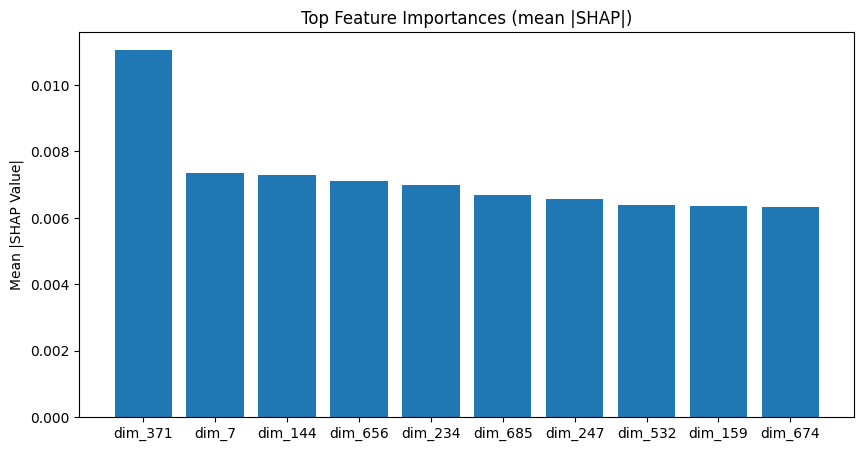

<ipython-input-43-882d0f70925b>:42: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(


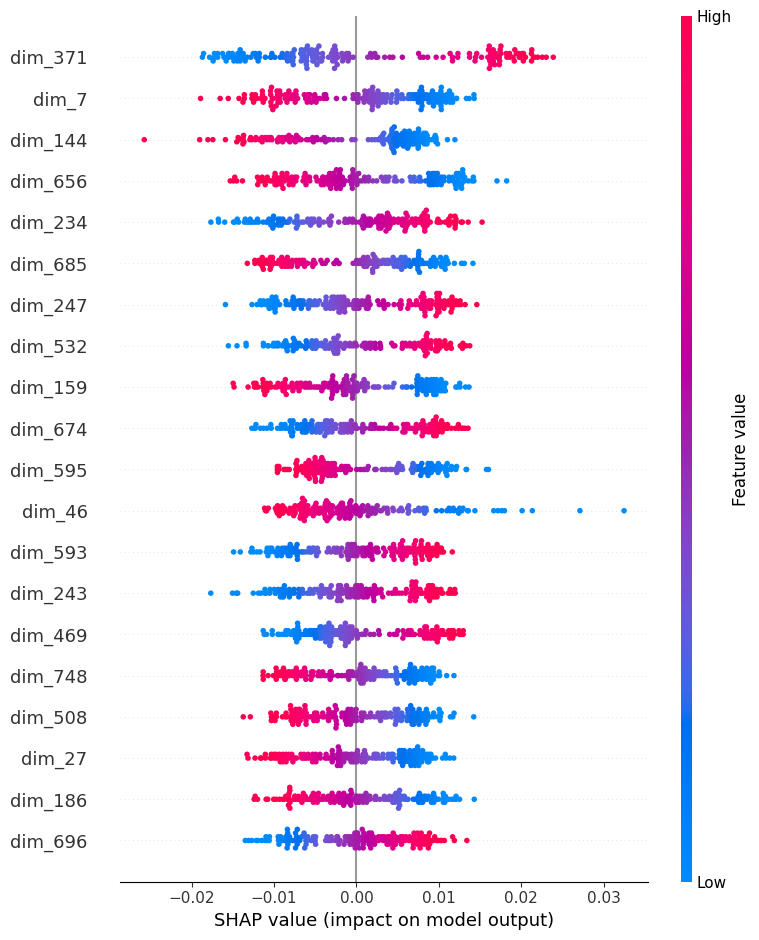

In [ ]:
import shap
import numpy as np
import matplotlib.pyplot as plt

# Optional: restrict background to first 50 samples for speed
background = cls_embeddings_test  # (M, D)
cls_embeddings = np.array(cls_embeddings_test)  # (N, D)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def predict_from_cls(X):
    X_tensor = torch.tensor(X, dtype=torch.float32).to(device)
    with torch.no_grad():
        return model.regressor(X_tensor).cpu().numpy()

# Create explainer
explainer = shap.Explainer(predict_from_cls, background, algorithm="permutation", max_evals=1600)

# Compute SHAP values for the full test set
shap_values = explainer(cls_embeddings)

# ----- GLOBAL AGGREGATION -----
# Compute mean absolute SHAP value per dimension (global importance)
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)  # shape: (D,)

# Sort and display top dimensions
top_k = 10
top_dims = np.argsort(mean_abs_shap)[::-1][:top_k]

print("Top SHAP dimensions (global importance):")
for i in top_dims:
    print(f"Dimension {i}: mean(|SHAP|) = {mean_abs_shap[i]:.4f}")

# Optional: bar plot for top-k
plt.figure(figsize=(10, 5))
plt.bar([f"dim_{i}" for i in top_dims], mean_abs_shap[top_dims])
plt.title("Top Feature Importances (mean |SHAP|)")
plt.ylabel("Mean |SHAP Value|")
plt.show()

# Optional SHAP summary plot (violin/beeswarm style)
shap.summary_plot(
    shap_values,
    cls_embeddings,
    feature_names=[f"dim_{i}" for i in range(cls_embeddings.shape[1])]
)


In [ ]:


cls_embeddings_test_distribution = [
    (embedding, label)
    for embedding, label in zip( cls_embeddings_test, preds_test)
]

Exploring dimension 667
Embedding dimension stats: mean=0.0988, std=0.2057
Pearson correlation with label: -0.7071 (p=1.3566e-28)


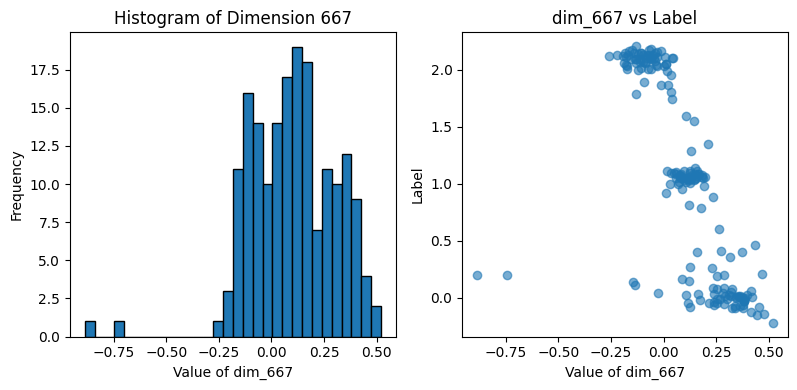

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import pearsonr

def plot_embedding_distribution(cls_embeddings_test_distribution, dimension_idx):
    """
    Plots distribution, label relationship, and statistics for a given CLS embedding dimension.

    Args:
        cls_embeddings_with_text: list of (text, embedding, label) tuples
        dimension_idx: integer, the dimension to explore
    """
    # Extract embeddings and labels
    embeddings = np.array([item[0] for item in cls_embeddings_test_distribution])  # shape (N, D)
    labels = np.array([item[1] for item in cls_embeddings_test_distribution])       # shape (N,)
    #print(labels)
    # Get the values of the selected dimension
    dim_values = embeddings[:, dimension_idx]

    print(f"Exploring dimension {dimension_idx}")
    print(f"Embedding dimension stats: mean={dim_values.mean():.4f}, std={dim_values.std():.4f}")

    # Pearson correlation between this dimension and labels
    corr, p_value = pearsonr(dim_values, labels)
    print(f"Pearson correlation with label: {corr:.4f} (p={p_value:.4e})")

    # --- Plot 1: Histogram of the dimension values
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.hist(dim_values, bins=30, edgecolor='k')
    plt.title(f"Histogram of Dimension {dimension_idx}")
    plt.xlabel(f"Value of dim_{dimension_idx}")
    plt.ylabel("Frequency")

    # --- Plot 2: Scatter plot of dimension value vs label
    plt.subplot(1, 3, 2)
    plt.scatter(dim_values, labels, alpha=0.6)
    plt.title(f"dim_{dimension_idx} vs Label")
    plt.xlabel(f"Value of dim_{dimension_idx}")
    plt.ylabel("Label")


    plt.tight_layout()
    plt.show()
# Suppose you have already trained and obtained:
# cls_embeddings_with_text_train = [(text, embedding, label), ...]

# Assume most important dimension from SHAP is 42
plot_embedding_distribution(cls_embeddings_test_distribution , dimension_idx=667)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np



# 1. Exact Match Accuracy
acc = 0
for i in range(len(truths_test)):
    if int(truths_test[i]) == int(scores_df['value'][i]):
        acc += 1
    #print(int(truths_test[i]), test_scores[i])
print("Exact Match Accuracy:", acc / len(truths_test))

# 2. Convert to NumPy arrays
y_true = np.array(truths_test, dtype=float)
y_pred = np.array(scores_df['value'], dtype=float)

# 3. Mean Absolute Error
mae = mean_absolute_error(y_true, y_pred)
print("Mean Absolute Error (MAE):", mae)

# 4. Root Mean Squared Error
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
print("Root Mean Squared Error (RMSE):", rmse)

# 5. R-squared
r2 = r2_score(y_true, y_pred)
print("R-squared (R²):", r2)


Exact Match Accuracy: 0.6166666666666667
Mean Absolute Error (MAE): 0.3888888888888889
Root Mean Squared Error (RMSE): 0.6324555320336759
R-squared (R²): 0.4
